In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.cnn as cnn
import train.train_model as train_model
import analysis.motif_compare as motif_compare
import analysis.motif_util as motif_util
import feature.simulated_dataset as simulated_dataset
import feature.experimental_dataset as experimental_dataset
import plot.plot_motifs as plot_motifs
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import tqdm.notebook

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define paths and constants

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
datasets = [
    "SPI1", "TAL/GATA", "E2F6", "JUND/TEAD", "REST", "SPI1/CTCF",
    "CTCF (HepG2)", "FOXA1 (HepG2)", "DNase (HL-60)"
]

In [6]:
datasets_sanit = {
    dataset_key : dataset_key.replace("/", "_").replace(" ", "").replace("(", "_").replace(")", "").lower()
    for dataset_key in datasets
}

In [7]:
cnn_model_paths = {
    "SPI1": os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/standard_cnn_with_filterreg/1/last_ckpt.pth"),
    "TAL/GATA": os.path.join(base_path, "models/trained_models/simulated/tal_gata_exp_mix/standard_cnn_with_filterreg/2/last_ckpt.pth"),
    "E2F6": os.path.join(base_path, "models/trained_models/simulated/e2f6_max_exp_coop/standard_cnn_with_filterreg/2/last_ckpt.pth"),
    "JUND/TEAD": os.path.join(base_path, "models/trained_models/simulated/jund_tead_exp_hard_spacing/standard_cnn_with_filterreg/2/last_ckpt.pth"),
    "REST": os.path.join(base_path, "models/trained_models/simulated/rest_exp_both/standard_cnn_with_filterreg/1/last_ckpt.pth"),
    "SPI1/CTCF": os.path.join(base_path, "models/trained_models/simulated/spi1_ctcf_exp_repress/standard_cnn_with_filterreg/2/last_ckpt.pth"),
    "CTCF (HepG2)": os.path.join(base_path, "models/trained_models/experimental/chipseq_ctcf_hepg2/standard_cnn_with_filterreg/1/last_ckpt.pth"),
    "FOXA1 (HepG2)": os.path.join(base_path, "models/trained_models/experimental/chipseq_foxa1_hepg2/standard_cnn_with_filterreg/1/last_ckpt.pth"),
    "DNase (HL-60)": os.path.join(base_path, "models/trained_models/experimental/dnase_hl60/standard_cnn_with_filterreg/2/last_ckpt.pth")
}

In [8]:
sim_motif_config_paths = {
    "SPI1": [os.path.join(base_path, "data/simulations/configs/spi1_exp_single_config.json")],
    "TAL/GATA": [os.path.join(base_path, "data/simulations/configs/tal_gata_exp_mix_config.json")],
    "E2F6": [os.path.join(base_path, "data/simulations/configs/e2f6_max_exp_coop_config.json"), os.path.join(base_path, "data/simulations/configs/e2f6_max_exp_coop_neg_config.json")],
    "JUND/TEAD": [os.path.join(base_path, "data/simulations/configs/jund_tead_exp_hard_spacing_config.json")],
    "REST": [os.path.join(base_path, "data/simulations/configs/rest_exp_both_config.json"), os.path.join(base_path, "data/simulations/configs/rest_exp_both_neg_config.json")],
    "SPI1/CTCF": [os.path.join(base_path, "data/simulations/configs/spi1_ctcf_exp_repress_config.json"), os.path.join(base_path, "data/simulations/configs/spi1_ctcf_exp_repress_neg_config.json")],
}

In [9]:
exp_peak_bed_paths = {
    "CTCF (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR607XFI_CTCF_HepG2/ENCFF664UGR_idrpeaks.bed.gz"),
    "FOXA1 (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR865RXA_FOXA1_HepG2/ENCFF081USG_idrpeaks.bed.gz"),
    "DNase (HepG2)": os.path.join(base_path, "data/encode/dnase/ENCSR149XIL_HepG2/ENCFF897NME_peaks.bed.gz"),
    "DNase (HL-60)": os.path.join(base_path, "data/encode/dnase/ENCSR889WKL_HL60/ENCFF773SFA_peaks.bed.gz"),
    "DNase (K562)": os.path.join(base_path, "data/encode/dnase/ENCSR000EKS_K562/ENCFF274YGF_peaks.bed.gz")
}

In [10]:
known_motifs_path = "/home/tsenga5/mechint_regnet/data/databases/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme_sanitname.txt"

In [11]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/cnn_with_filterreg"
os.makedirs(figures_out_path, exist_ok=True)

### Import model motifs

In [12]:
def model_to_pfms(model, data_loader, max_thresh_frac=0.5):
    """
    Given a model and a data loader, runs through the input sequences
    in the data loader and collects convolutional activations from the
    entire epoch.
    Returns a F x W x 4 array of PFMs for the filters. If a filter is
    never activated, its PFM will be all 0.
    """
    _, _, _, _, model_outputs_other, input_data = \
        train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)
    conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
    input_seqs = input_data[0]  # Shape: N x L x 4
    num_filters = conv_acts.shape[2]
    filter_width = input_seqs.shape[1] - conv_acts.shape[1] + 1

    # Compute minimum activations needed
    act_threshes = np.max(conv_acts, axis=(0, 1)) * max_thresh_frac

    # Construct PFMs
    pfms = np.zeros((num_filters, filter_width, 4))
    for i in range(num_filters):
        if act_threshes[i] == 0:
            continue
        ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
        if not ex_inds.size:
            # Nothing passed the threshold
            continue
        # Trick to get all matching subsequences, where we flatten the set of all
        # indices we want and then reshape
        seqs = input_seqs[
            np.repeat(ex_inds, filter_width),
            (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
        ].reshape(len(ex_inds), filter_width, -1)
        pfms[i] = np.mean(seqs, axis=0)

    return pfms

In [13]:
# For each dataset, create a data loader and use it to compute PFMs and activation frequencies
cnn_pfms = {}
cnn_pfms_used = {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    # Create dataloader
    if dataset_key in sim_motif_config_paths:
        data_loader = simulated_dataset.dataset_ex.run(
            "create_data_loader", config_updates={
                "motif_config_path": sim_motif_config_paths[dataset_key][0],  # Only the positive labels
                "input_length": 500,
                "motif_center_dist_bound": 50,
                "batch_size": 100,
                "num_batches": 100,  # 10K sequences
                "negative_ratio": 0,  # No negatives
                "background_match_reject_prob": 1,
                "neg_motif_config_path": None  # No negatives, so ignore this field
            }
        ).result
    else:
        data_loader = experimental_dataset.dataset_ex.run(
            "create_data_loader", config_updates={
                "peaks_bed_path": exp_peak_bed_paths[dataset_key],
                "batch_size": 128,
                "chrom_set": ["chr1"],  # Test set,
                "negative_ratio": 0  # No negatives
            }
        ).result
    data_loader.dataset.on_epoch_start()

    cnn_model = model_util.load_model(
        cnn.ConvNet, cnn_model_paths[dataset_key]
    ).to(DEVICE)
    cnn_pfms[dataset_key] = model_to_pfms(cnn_model, data_loader)
    cnn_pfms_used[dataset_key] = [np.sum(pfm) > 0 for pfm in cnn_pfms[dataset_key]]

  0%|          | 0/9 [00:00<?, ?it/s]

WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x1493b71f36b0>
INFO - sim_dataset - Completed after 0:00:00

	Loss: 1.3744: 100%|████████████████████████████████████████████████████████████

### Compute top motif matches

In [14]:
def extract_tomtom_matches(num_motifs, tomtom_matches):
    """
    Takes a dictionary of TOMTOM matches (keys are indices) and a maximum
    number of motifs, and returns a list of length `num_motifs`, where each
    entry is a list of tuples of the matches (each tuple is the matched motif
    key, whether or not the match is reverse-complemented, and the -log(q-value).
    """
    result = [None] * num_motifs
    for i in range(num_motifs):
        try:
            subtable = tomtom_matches[i]
            subtable = subtable.sort_values("q-value")
            subtable["RC"] = subtable["Orientation"] == "-"
            subtable["Score"] = -np.log10(subtable["q-value"])
            result[i] = [tuple(row) for row in subtable[["Target_ID", "RC", "Score"]].values]
        except KeyError:
            result[i] = []
    return result

In [15]:
# Compute similarities for each
cnn_sims = {}
true_pfms = {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    # Import true motifs
    if dataset_key in sim_motif_config_paths:
        # Simulation
        true_pfms[dataset_key] = {}
        motif_files = []
        for config_path in sim_motif_config_paths[dataset_key]:
            with open(config_path, "r") as f:
                motif_config = json.load(f)
                motif_files.extend(motif_config["motif_files"])
        motif_files = list(set(motif_files))
        for motif_file in motif_files:
            true_pfms[dataset_key].update({
                key : val for key, val in motif_util.import_meme_motifs(motif_file).items()
                if key.endswith("_exp")
            })
    else:
        # Experimental
        true_pfms[dataset_key] = motif_util.import_meme_motifs(known_motifs_path)
        
    # Run TOMTOM to match each discovered motif to the true motifs
    cnn_subtables = motif_compare.run_tomtom(
        {i : pfm for i, pfm in enumerate(cnn_pfms[dataset_key]) if cnn_pfms_used[dataset_key][i]},
        true_pfms[dataset_key]
    )

    # Collect top matches for each motif
    cnn_sims[dataset_key] = extract_tomtom_matches(len(cnn_pfms[dataset_key]), cnn_subtables)

  0%|          | 0/9 [00:00<?, ?it/s]

### Plot motifs

SPI1


/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/gr

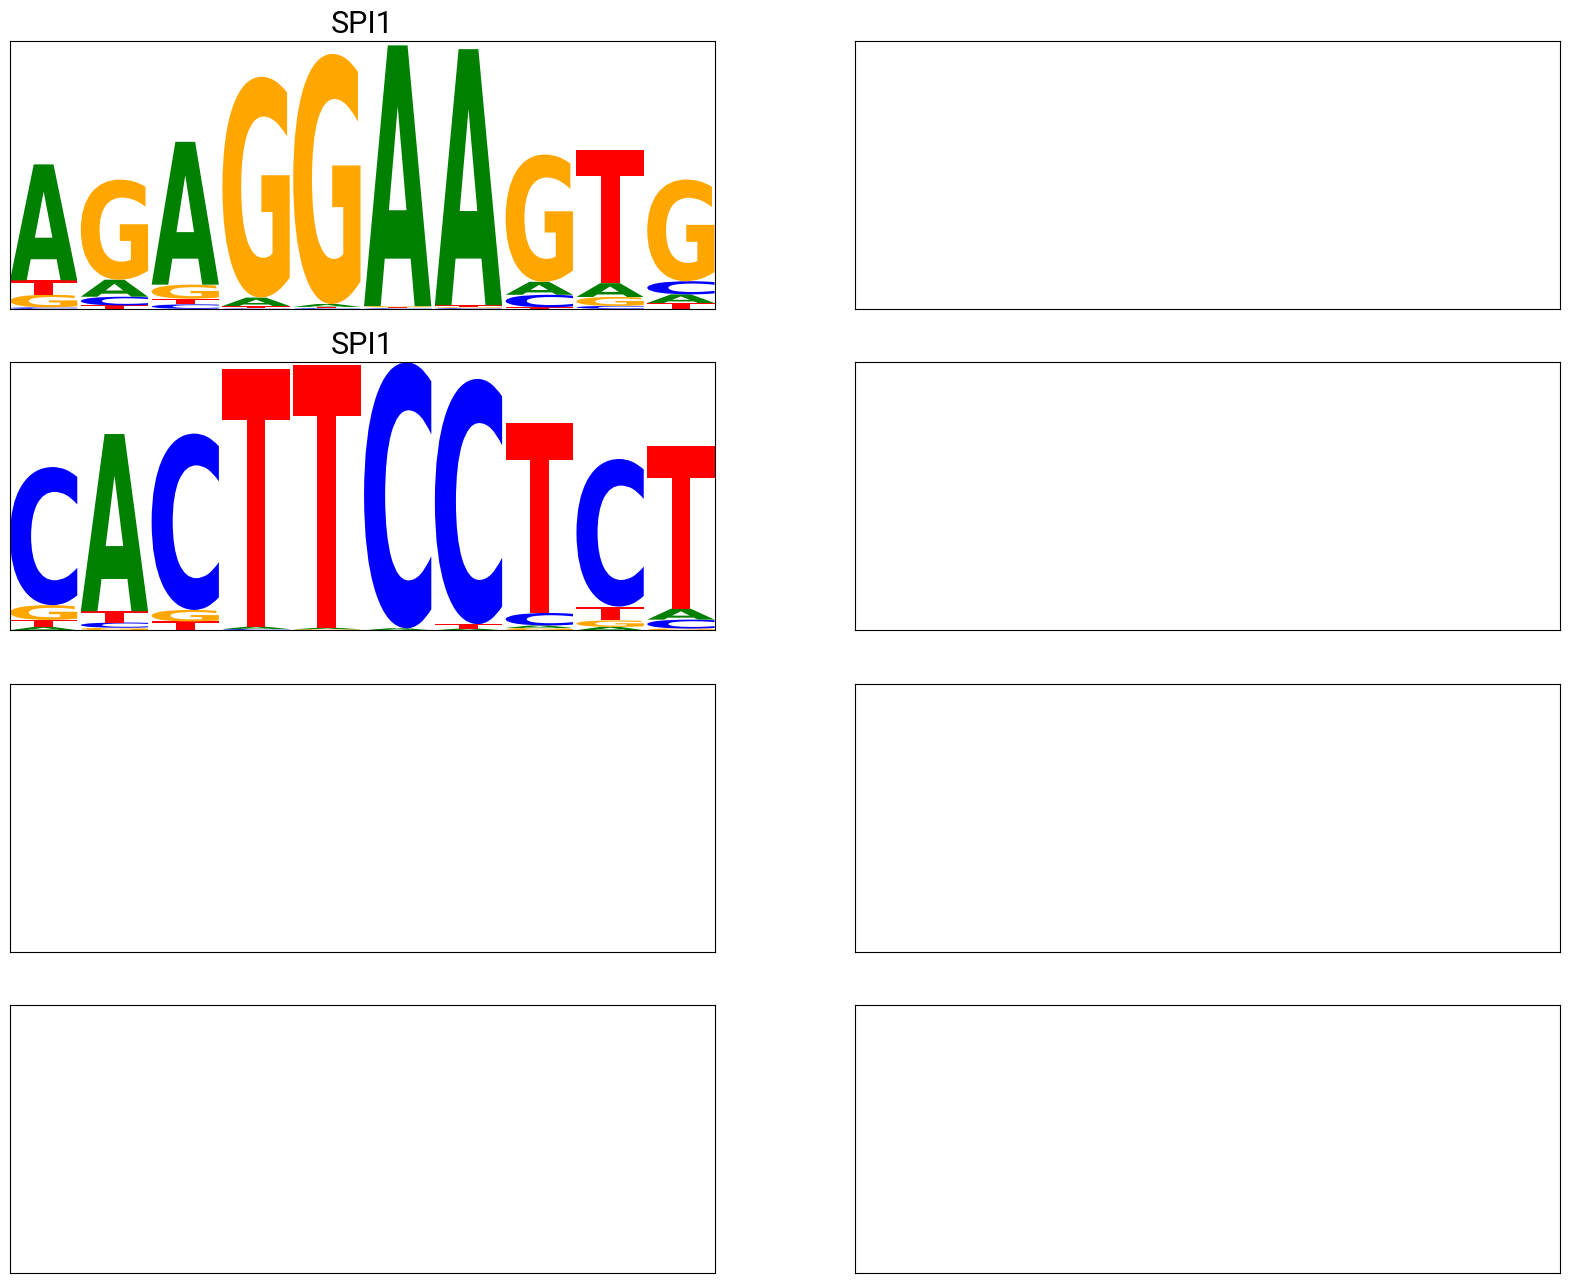

TAL/GATA


/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


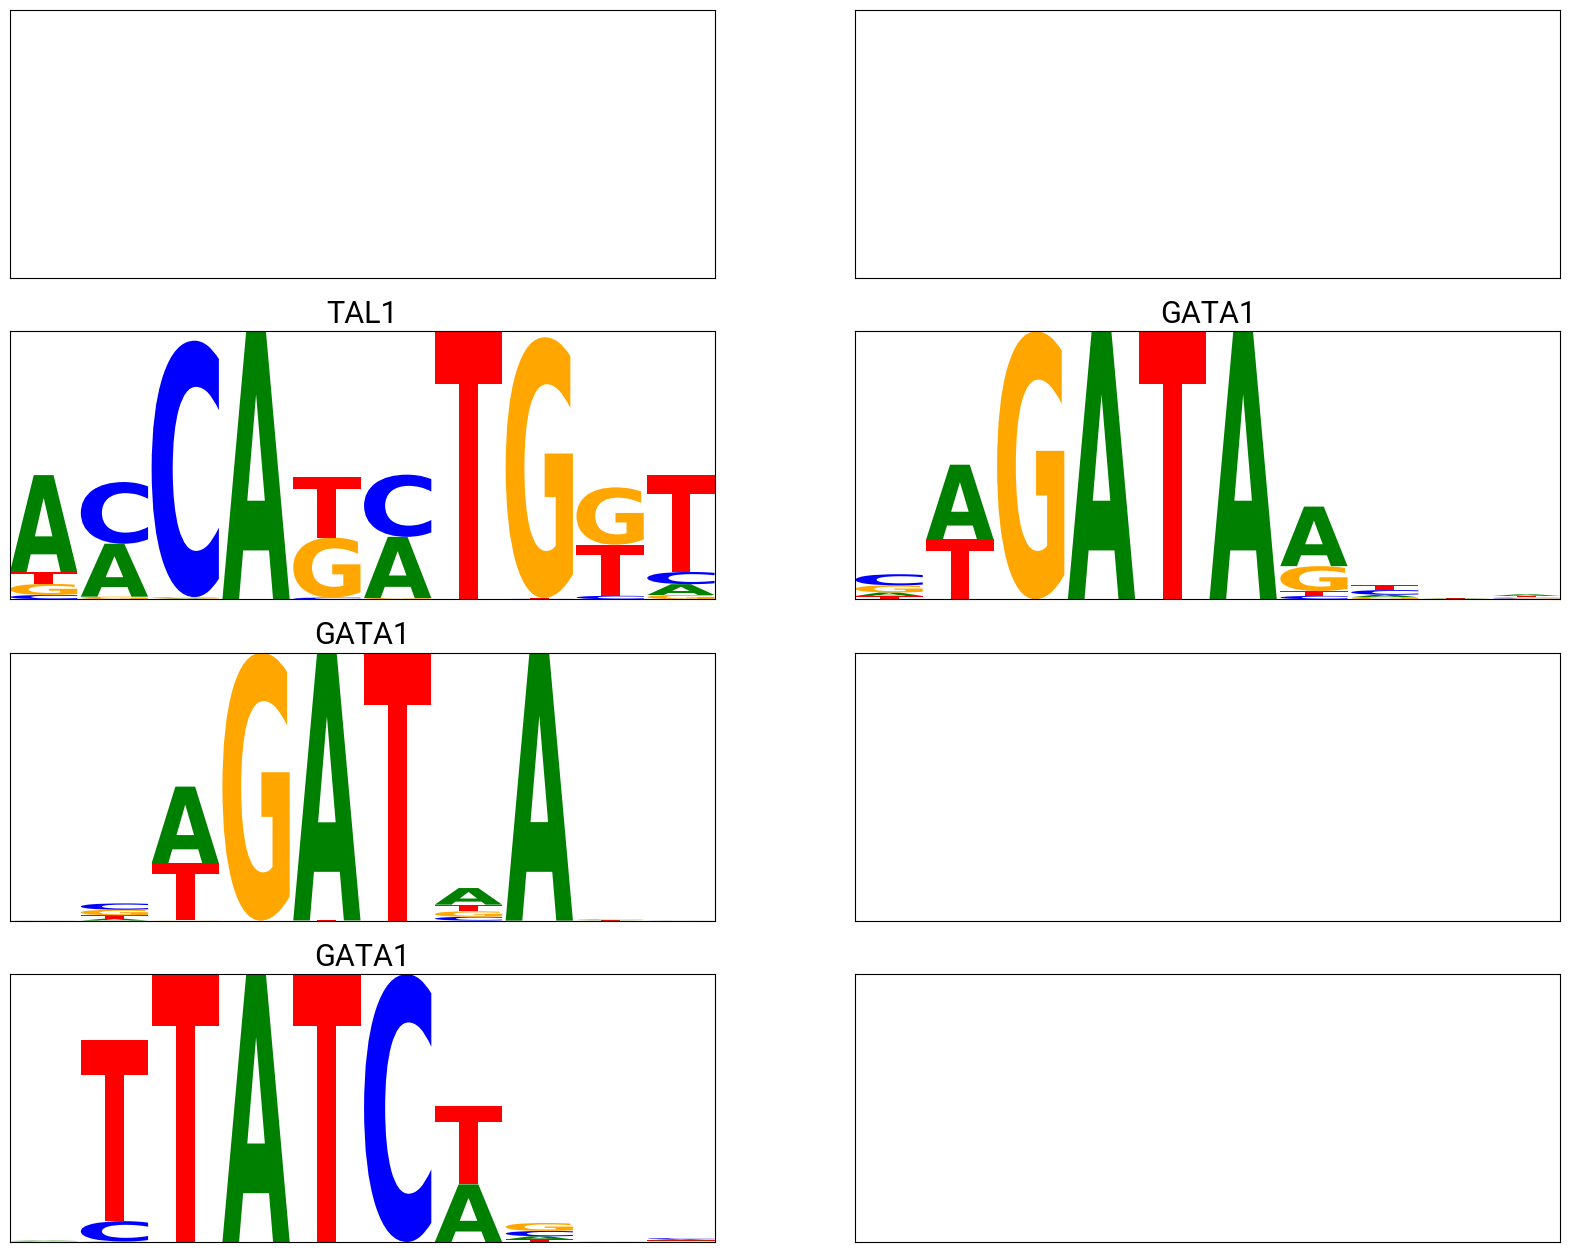

E2F6


/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/gr

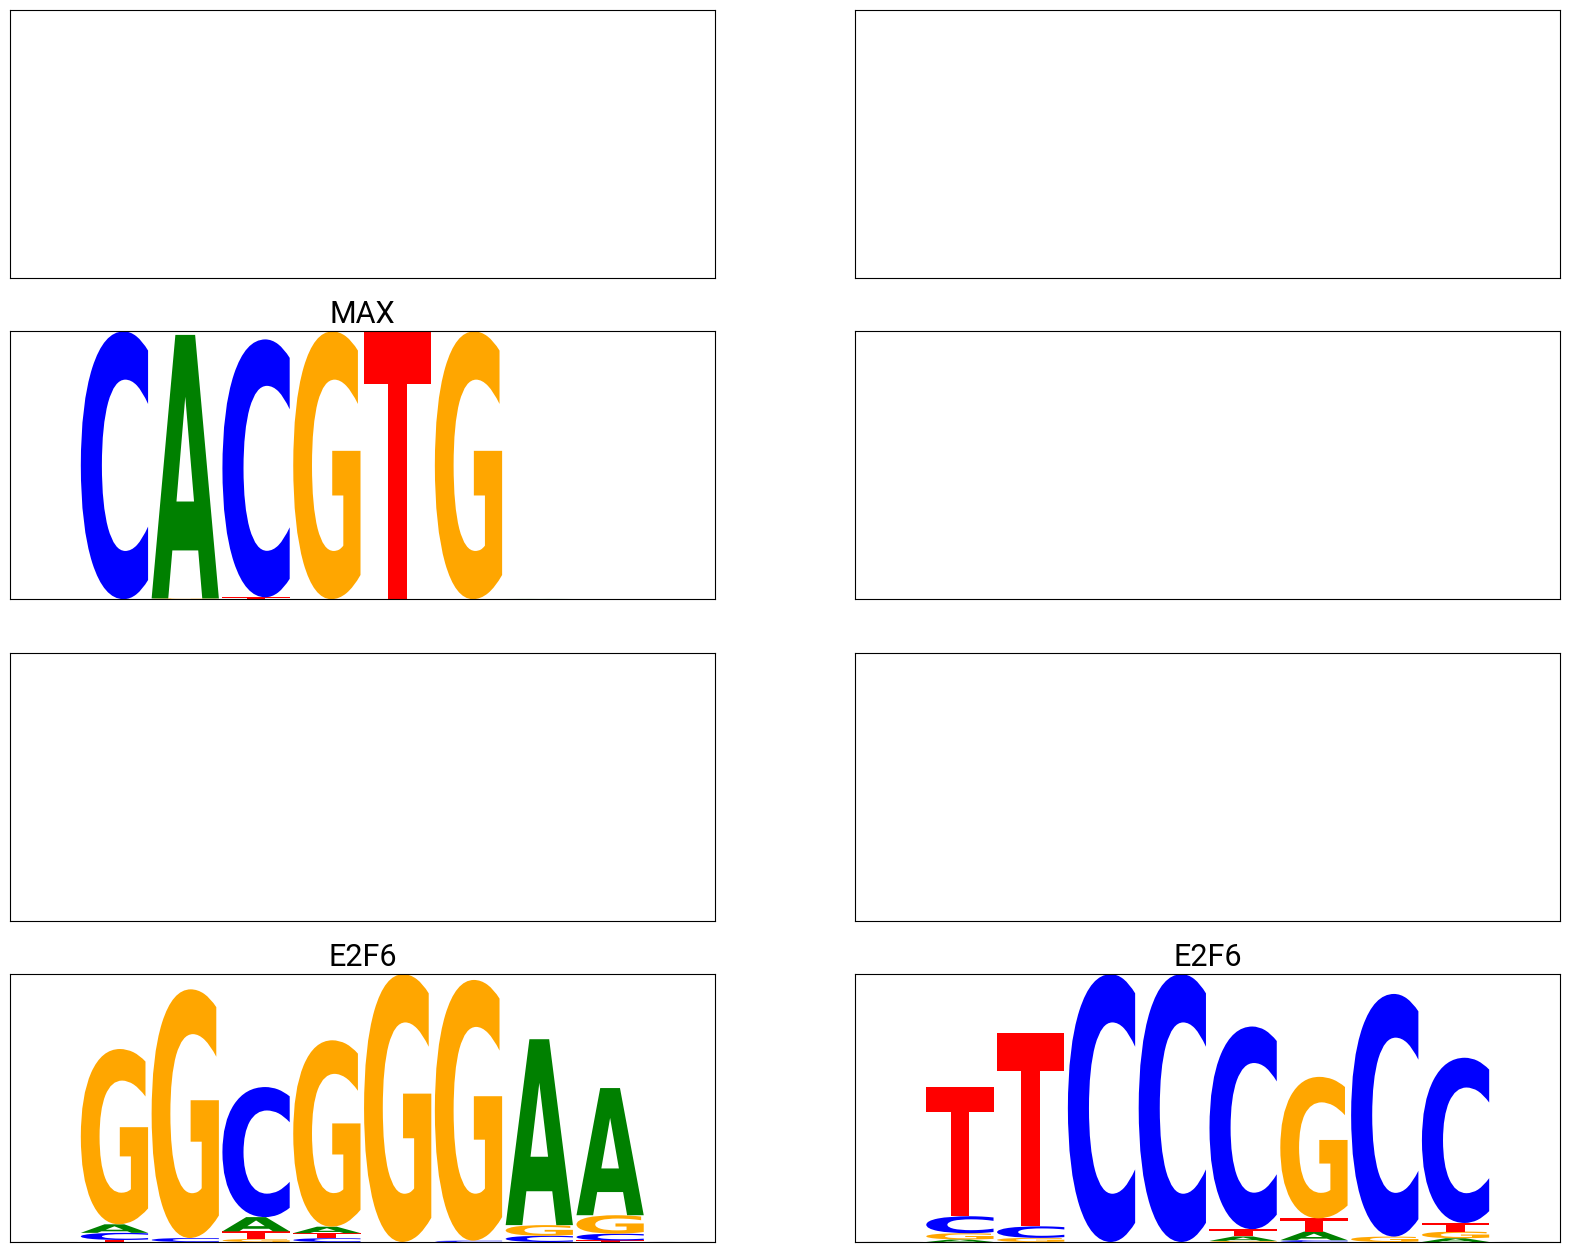

JUND/TEAD


/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/gr

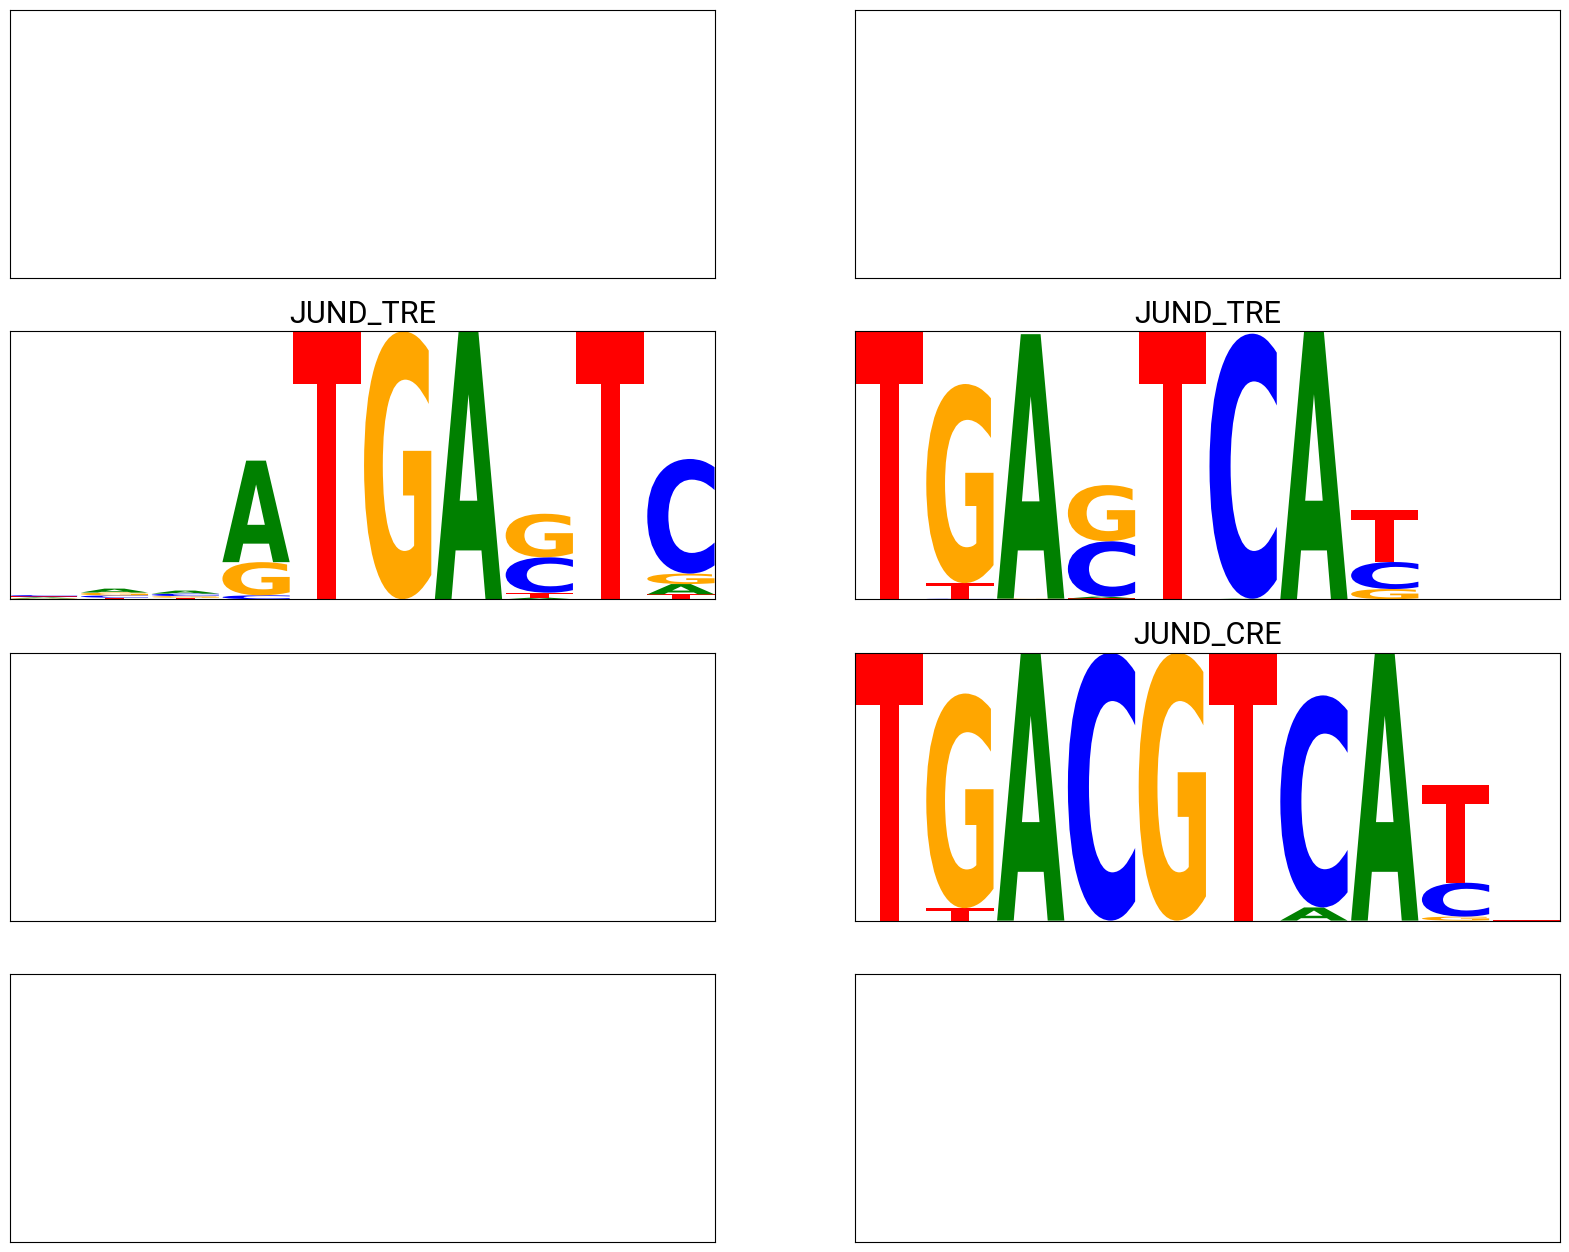

REST


/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


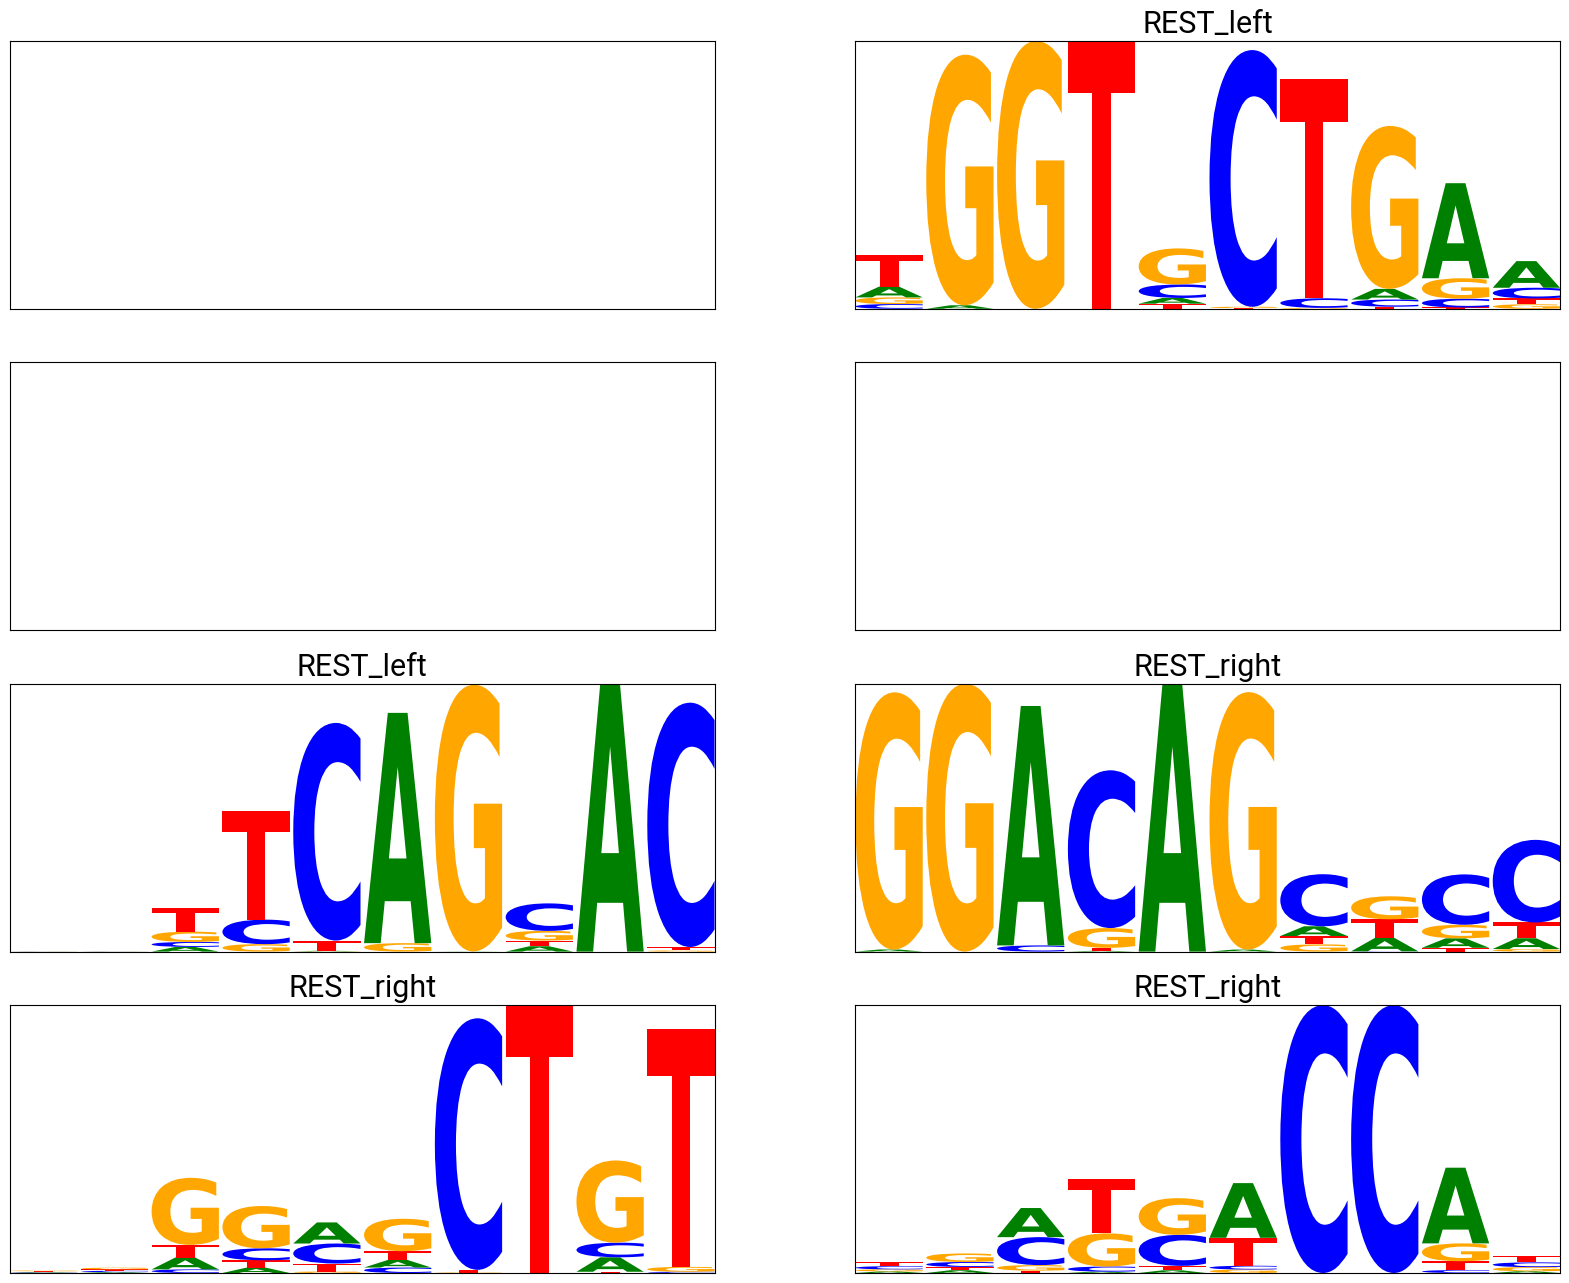

SPI1/CTCF


/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


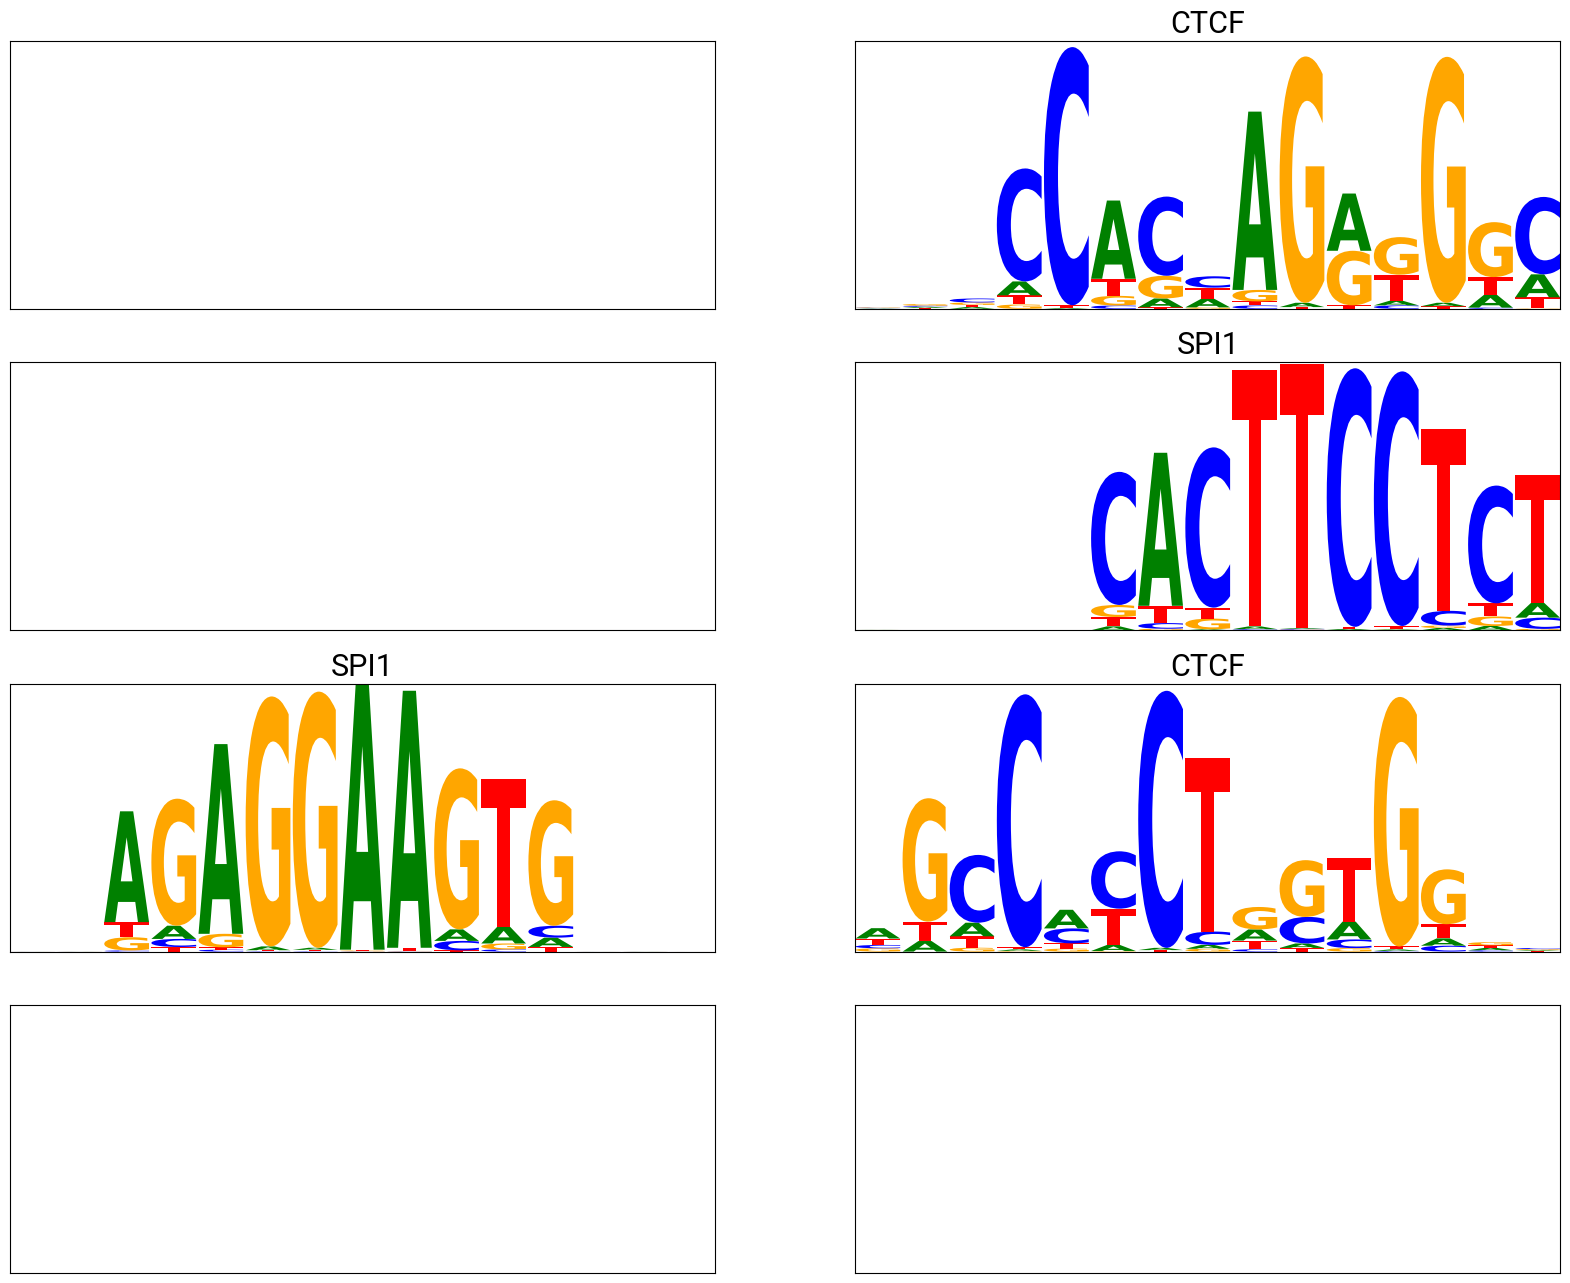

CTCF (HepG2)


/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


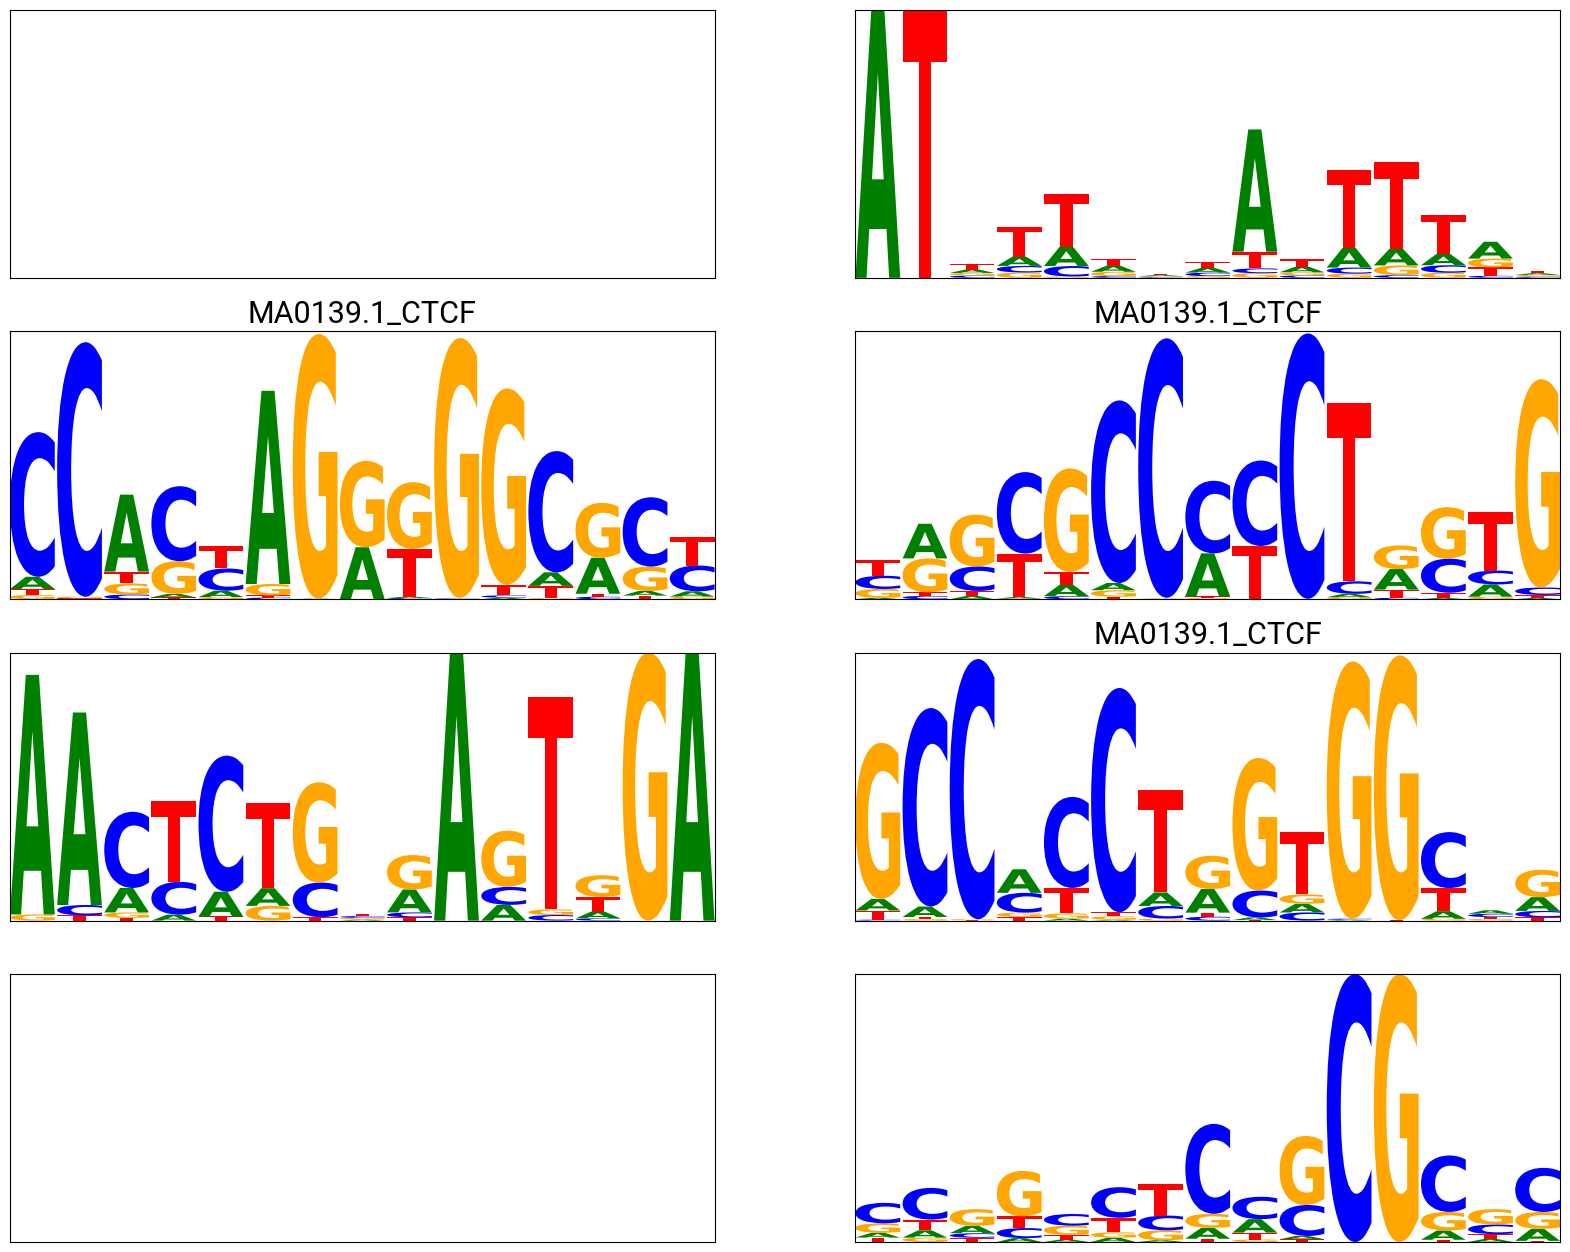

FOXA1 (HepG2)


/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


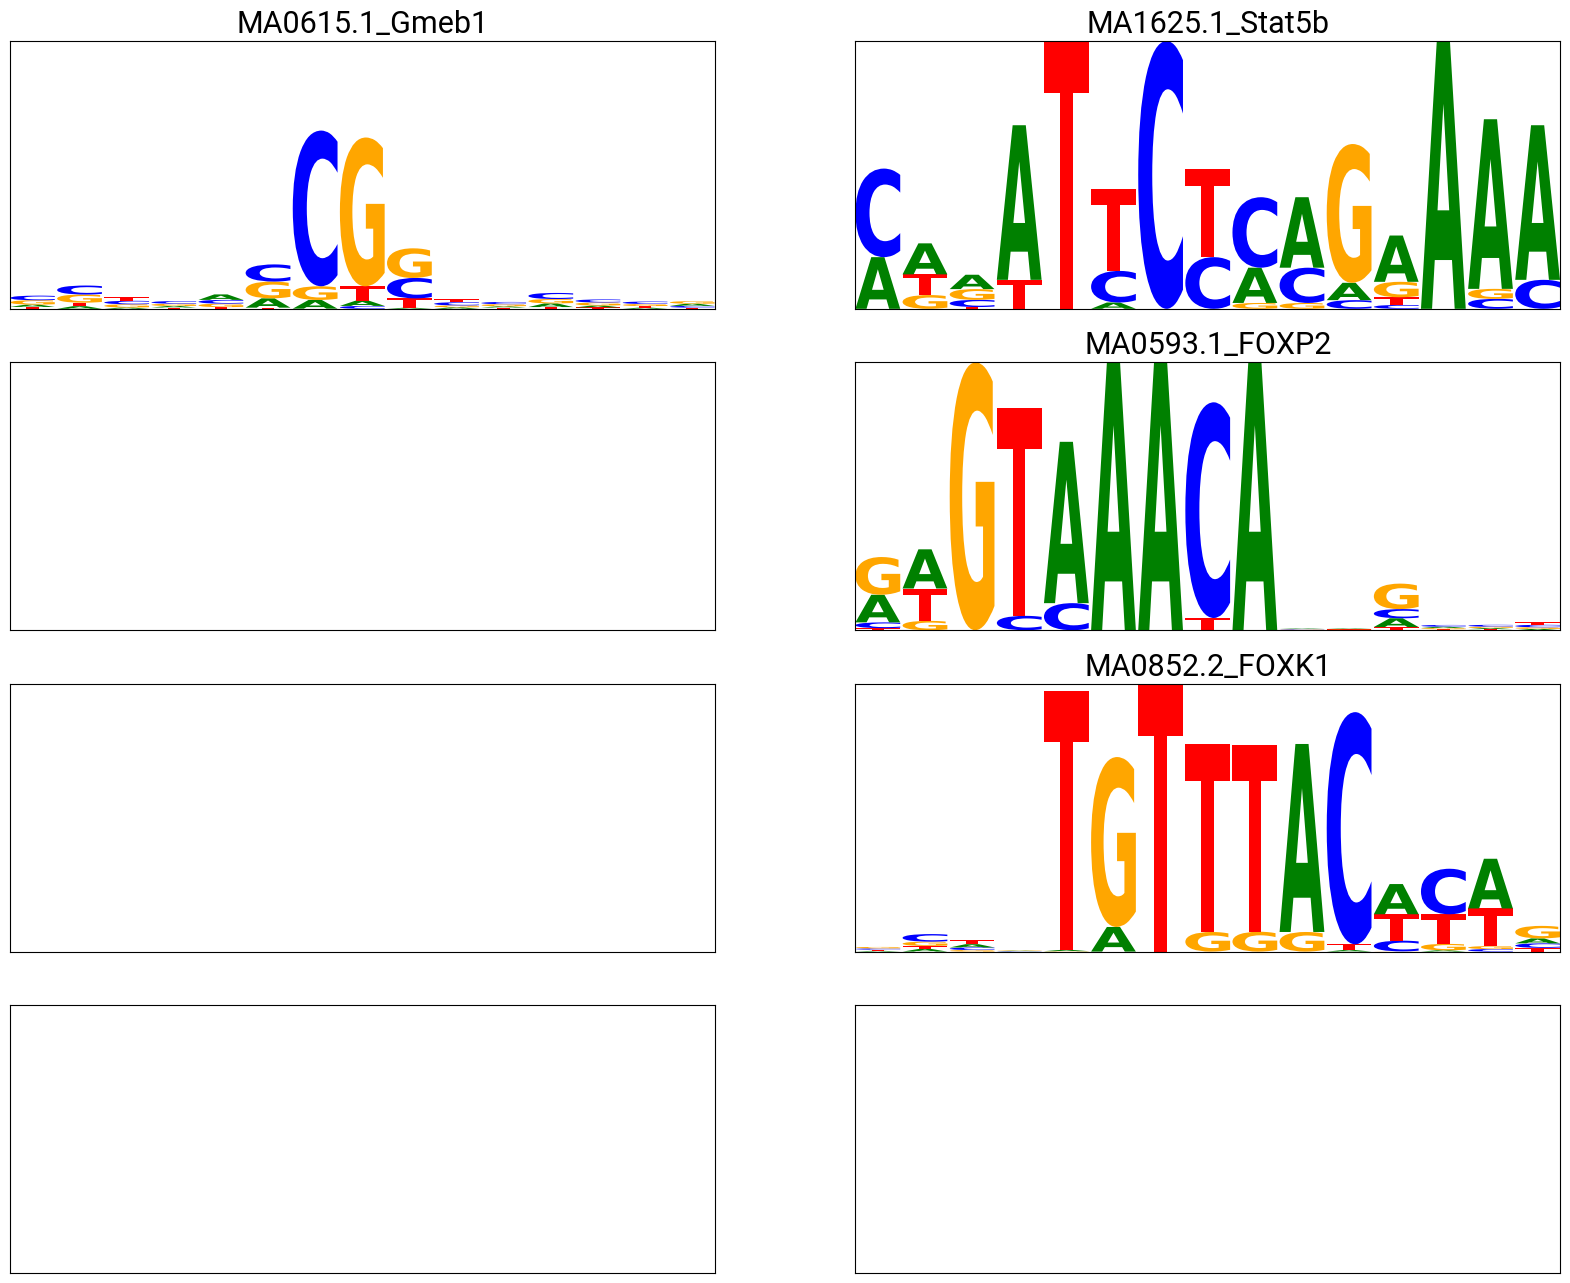

DNase (HL-60)


/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/gr

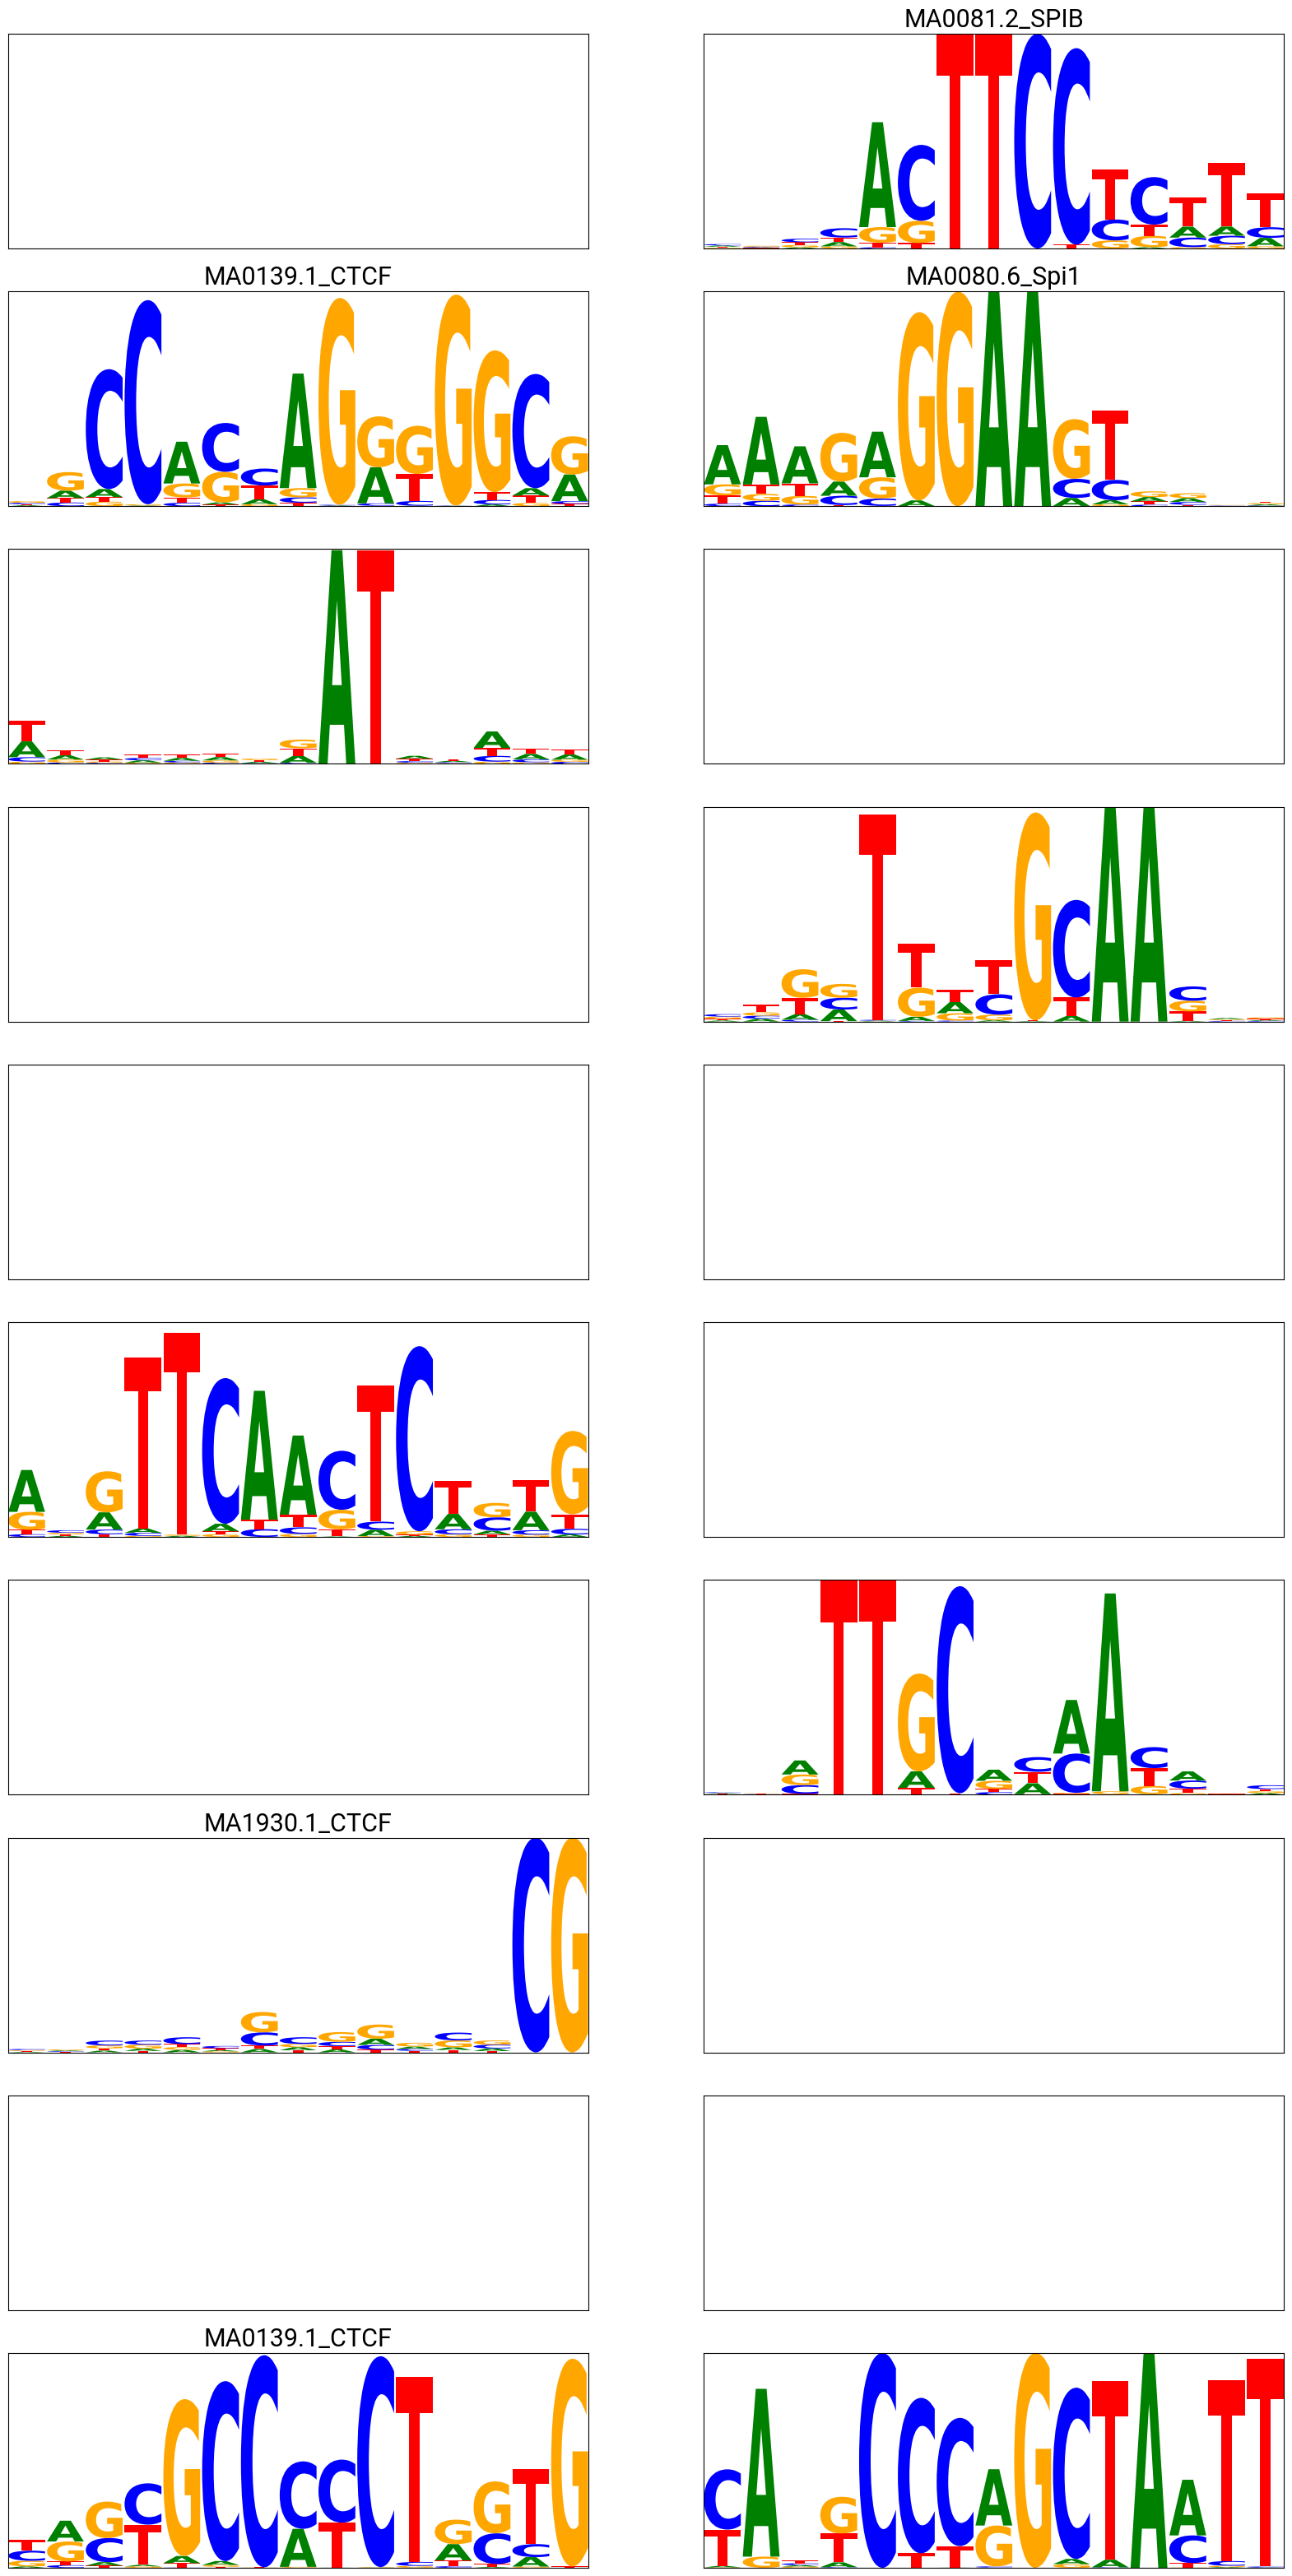

In [17]:
for dataset_key in datasets:
    print(dataset_key)
    fig = plot_motifs.plot_motif_grid(
        [pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in cnn_pfms[dataset_key]],
        titles=[
            cnn_sims[dataset_key][i][0][0].rstrip("_exp") if cnn_pfms_used[dataset_key][i] and cnn_sims[dataset_key][i] else ""
            for i in range(len(cnn_pfms[dataset_key]))
        ],
        show_x=False, show_y=False
    )
    fig.savefig(os.path.join(figures_out_path, datasets_sanit[dataset_key] + "_cnn_filterreg_filter_motifs.svg"), format="svg")
    plt.show()